# Re Evaluate the data

In [52]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import modules.missing as ms
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
import toad
from toad.plot import bin_plot, badrate_plot
from toad.metrics import KS, AUC

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, balanced_accuracy_score

## Load Data

In [7]:
app_train = pd.read_csv('../data/application_train_cleaned.csv')
bb = pd.read_csv('../data/bureau_balance.csv')
bureau = pd.read_csv('../data/bureau_clean.csv')
ccb = pd.read_csv('../data/credit_card_balance_clean.csv')
installments = pd.read_csv('../data/installments_payments_clean.csv')
pos_cash = pd.read_csv('../data/pos_cash_balance_clean.csv')
previous = pd.read_csv('../data/previous_application_clean1.csv')

## Bureau data group by and joining

bb aggragate to show average MONTHS_BALANCE()

In [8]:
# aggreagate bureau balance Months' balance with mean for every unique bureau id
bb_agg = bb.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].mean().reset_index(name='AVG_MONTHS_BALANCE')

# join aggregated bureau balance with bureau
bureau_semi_join = pd.merge(bureau, bb_agg, on='SK_ID_BUREAU', how='left')

# aggregate current credit amount and current debt(on credit bureau) with sum for every unique current application id
bureau_agg = bureau_semi_join.groupby('SK_ID_CURR')[['AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT']].sum().reset_index()

## Join bureau and application train

In [9]:
# left join application train with aggregated bureau 
train_bureau = pd.merge(app_train, bureau_agg, on='SK_ID_CURR', how='left')

## Payment installments aggregation and feature creation

In [10]:
# installment payment data joining and aggregating
installments_agg = installments.groupby(['SK_ID_PREV', 'SK_ID_CURR'])[['AMT_INSTALMENT', 'AMT_PAYMENT']].sum().reset_index()

# Differences between annuity installment and the client actually paid, 
# the more the value is far away from 0 the more probability of client to be a bad client 
installments_agg['DIFF_INSTALLMENT_PAYMENT'] = installments_agg['AMT_INSTALMENT'] - installments_agg['AMT_PAYMENT']
installments_agg = installments_agg.drop(columns='SK_ID_CURR', axis=1)

## Join payment isntallments with previous application

In [11]:
# join installment with previous application
prev_installments = pd.merge(previous, installments_agg, on='SK_ID_PREV', how='left')

## Credit Card Balance Aggregate and Join

In [12]:
ccb_agg = ccb.groupby('SK_ID_PREV')[['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT']].sum().reset_index()

prev_ccb = pd.merge(prev_installments, ccb_agg, on='SK_ID_PREV', how='left')

## Pos Cash Balance Aggregate and Join

In [13]:
pc_agg = pos_cash.groupby('SK_ID_PREV')['SK_DPD'].mean().reset_index(name='AVERAGE_DPD')

prev_pc = pd.merge(prev_ccb, pc_agg, on='SK_ID_PREV', how='left')

## Train Full

In [14]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))

In [15]:
# train_full.to_csv('../data/train_full.csv', index=False)

In [16]:
pd.set_option('display.max_columns', None)

display(train_full.sample(10))
print(f'Application train data contains: \n{train_full.shape[0]} rows and {train_full.shape[1]} columns')
print(f'\nApplication train data information:\n')
print(train_full.info())
print(f'\nStatistical Summary of numerical columns:\n')

numerical = train_full.select_dtypes(include='number')
display(numerical.describe())

categorical = train_full.select_dtypes(include='object')
display(categorical.describe())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START_curr,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,NAME_CONTRACT_TYPE_prev,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,WEEKDAY_APPR_PROCESS_START_prev,HOUR_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
1353379,437194,0,Cash loans,F,N,Y,0,180000.0,896643.0,35689.5,724500.0,Unaccompanied,State servant,Higher education,Married,House / apartment,0.006233,-16911,-1436,-4833.0,-447,1,1,0,1,0,0,2.0,2,2,THURSDAY,17,0,0,0,0,0,0,School,0.675202,5.0,0.0,5.0,0.0,-2349.0,1310080.500,898902.000,2810508.0,Cash loans,0.000,0.000,0.0,0.000,TUESDAY,14.0,Y,1.0,XNA,Canceled,-23.0,XNA,XAP,Repeater,XNA,XNA,XNA,Credit and cash offices,-1.0,XNA,0.0,XNA,Cash,0.0,NaN,NaN,NaN,NaN,NaN,NaN
769682,292607,0,Cash loans,F,N,Y,0,63000.0,328581.0,17955.0,265500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.020246,-15886,-1426,-5819.0,-4197,1,1,0,1,1,0,2.0,3,3,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.542405,0.0,0.0,0.0,0.0,-1563.0,2515340.025,1185230.700,2129600.0,Cash loans,0.000,0.000,0.0,0.000,FRIDAY,6.0,Y,1.0,XNA,Canceled,-70.0,XNA,XAP,Repeater,XNA,XNA,XNA,Credit and cash offices,-1.0,XNA,0.0,XNA,Cash,0.0,NaN,NaN,NaN,NaN,NaN,NaN
177144,144130,1,Cash loans,M,Y,Y,0,135000.0,359374.5,28944.0,333000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.035792,-8819,-481,-3529.0,-1493,1,1,0,1,0,0,1.0,2,2,SATURDAY,13,0,0,0,0,0,0,Self-employed,0.750979,0.0,0.0,0.0,0.0,-1423.0,261576.000,18759.330,1772335.0,Consumer loans,5686.875,56430.000,47430.0,56430.000,THURSDAY,19.0,Y,1.0,XAP,Approved,-1423.0,Cash through the bank,XAP,New,Mobile,POS,XNA,Country-wide,40.0,Connectivity,12.0,high,POS mobile with interest,-1056.0,90937.530,68216.265,22721.265,NaN,NaN,2.076923
605135,251463,0,Cash loans,M,Y,N,1,315000.0,1255680.0,41629.5,1125000.0,Unaccompanied,Working,Secondary / secondary special,Married,Rented apartment,0.010006,-13015,-1141,-1112.0,-2222,1,1,1,1,0,0,3.0,2,1,TUESDAY,15,0,0,0,0,1,1,Industry: type 9,0.641229,0.0,0.0,0.0,0.0,-479.0,4309025.580,2896141.995,1104311.0,Consumer loans,4479.615,49455.000,49455.0,49455.000,SATURDAY,19.0,Y,1.0,XAP,Approved,-479.0,Cash through the bank,XAP,New,Computers,POS,XNA,Country-wide,100.0,Consumer electronics,12.0,low_action,POS household without interest,-118.0,53749.890,53749.890,0.000,NaN,NaN,0.000000
1188415,395032,0,Revolving loans,M,N,Y,0,135000.0,180000.0,9000.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.015221,-9012,-904,-4872.0,-1661,1,1,1,1,0,0,2.0,2,2,THURSDAY,13,0,0,0,0,0,0,Business Entity Type 3,0.276738,0.0,0.0,0.0,0.0,-646.0,1970307.000,1217398.500,2386066.0,Consumer loans,5287.725,49740.075,39226.5,49740.075,THURSDAY,9.0,Y,1.0,XAP

Application train data contains: 
1430155 rows and 79 columns

Application train data information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1430155 entries, 0 to 1430154
Data columns (total 79 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   SK_ID_CURR                       1430155 non-null  int64  
 1   TARGET                           1430155 non-null  int64  
 2   NAME_CONTRACT_TYPE_curr          1430155 non-null  object 
 3   CODE_GENDER                      1430155 non-null  object 
 4   FLAG_OWN_CAR                     1430155 non-null  object 
 5   FLAG_OWN_REALTY                  1430155 non-null  object 
 6   CNT_CHILDREN                     1430155 non-null  int64  
 7   AMT_INCOME_TOTAL                 1430155 non-null  float64
 8   AMT_CREDIT_curr                  1430155 non-null  float64
 9   AMT_ANNUITY_curr                 1430155 non-null  float64
 10  AMT_GOODS_PRIC

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_curr,AMT_ANNUITY_curr,AMT_GOODS_PRICE_curr,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START_curr,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,SK_ID_PREV,AMT_ANNUITY_prev,AMT_APPLICATION,AMT_CREDIT_prev,AMT_GOODS_PRICE_prev,HOUR_APPR_PROCESS_START_prev,NFLAG_LAST_APPL_IN_DAY,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_LAST_DUE,AMT_INSTALMENT,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AMT_BALANCE,AMT_PAYMENT_TOTAL_CURRENT,AVERAGE_DPD
count,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.430155e+06,1.254670e+06,1.254670e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,1.413701e+06,8.205850e+05,8.205850e+05,8.205850e+05,7.828500e+04,7.828500e+04,769614.000000
mean,2.784702e+05,8.624240e-02,4.038870e-01,1.736036e+05,5.893386e+05,2.704027e+04,5.289922e+05,2.079102e-02,-1.631495e+04,6.860209e+04,-5.001275e+03,-3.034492e+03,9.999993e-01,8.067175e-01,1.824732e-01,9.989917e-01,2.825792e-01,7.195793e-02,2.149003e+00,2.058179e+00,2.036176e+00,1.199401e+01,1.229377e-02,4.435953e-02,3.626041e-02,7.368082e-02,2.220151e-01,1.738609e-01,5.110974e-01,1.538150e+00,1.532512e-01,1.520324e+00,1.074548e-01,-1.076470e+03,2.048573e+06,6.631244e+05,1.922744e+06,1.239553e+04,1.752436e+05,1.963539e+05,1.752686e+05,1.247893e+01,9.964321e-01,-8.803670e+02,3.149878e+02,1.256367e+01,4.623661e+04,2.328081e+05,2.352289e+05,-2.420824e+03,2.035212e+06,2.677531e+05,1.021295
std,1.028021e+05,2.807218e-01,7.165176e-01,1.983303e+05,3.874204e+05,1.404126e+04,3.559720e+05,1.339810e-02,4.346737e+03,1.451967e+05,3.551626e+03,1.507182e+03,8.361967e-04,3.948728e-01,3.862342e-01,3.173746e-02,4.502536e-01,2.584183e-01,9.001609e-01,4.963435e-01,4.891555e-01,3.233163e+00,1.101937e-01,2.058927e-01,1.869375e-01,2.612509e-01,4.156014e-01,3.789899e-01,1.918513e-01,2.525672e+00,4.646596e-01,2.503920e+00,3.780070e-01,8.036990e+02,3.767452e+06,1.598177e+06,5.327153e+05,1.457276e+04,2.936222e+05,3.194812e+05,2.936438e+05,3.331474e+00,5.962560e-02,7.835402e+02,7.695082e+03,1.448807e+01,1.221605e+05,3.363216e+05,3.632959e+05,9.626145e+04,3.118154e+06,4.500664e+05,21.751332
min,1.000020e+05,0.000000e+00,0.000000e+00,2.565000e+04,4.500000e+04,0.000000e+00,0.000000e+00,2.900000e-04,-2.522900e+04,-1.791200e+04,-2.467200e+04,-7.197000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.292000e+03,0.000000e+00,-6.981558e+06,1.000001e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.922000e+03,-1.000000e+00,0.000000e+00,-2.889000e+03,0.000000e+00,2.070000e+00,-3.195000e+06,-1.260000e+05,0.000000e+00,0.000000
25%,1.893610e+05,0.000000e+00,0.000000e+00,1.125000e+05,2.700000e+05,1.679850e+04,2.385000e+05,1.003200e-02,-1.997500e+04,-2.825000e+03,-7.509000e+03,-4.319000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+

,NAME_CONTRACT_TYPE_curr,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,WEEKDAY_APPR_PROCESS_START_curr,ORGANIZATION_TYPE,NAME_CONTRACT_TYPE_prev,WEEKDAY_APPR_PROCESS_START_prev,FLAG_LAST_APPL_PER_CONTRACT,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,NAME_SELLER_INDUSTRY,NAME_YIELD_GROUP,PRODUCT_COMBINATION
count,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1430155,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701,1413701
unique,2,3,2,2,7,8,5,6,6,7,58,4,7,2,25,4,4,9,4,27,5,3,8,11,5,18
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,TUESDAY,Business Entity Type 3,Cash loans,WEDNESDAY,Y,XAP,Approved,Cash through the bank,XAP,Repeater,XNA,POS,XNA,Credit and cash offices,XNA,XNA,Cash
freq,1320679,964822,947544,1031672,1171310,730613,1046822,921040,1279761,251516,308918,626764,215519,1406387,786937,886099,882700,1145533,1037682,797209,592460,900053,600342,715322,429198,235101


In [17]:
xna_goods = train_full.NAME_GOODS_CATEGORY.value_counts()[0]
total_data = train_full.shape[0]
print(f'Proportion of XNA values in NAME_GOODS_CATEGORY {round((xna_goods / total_data) * 100, 2)}%')

xna_client = train_full.NAME_CLIENT_TYPE.value_counts()[0]
print(f'Proportion of XNA values in NAME_CLIENT_TYPE: {round((xna_client / total_data) * 100, 2)}%')


Proportion of XNA values in NAME_GOODS_CATEGORY 55.74%
Proportion of XNA values in NAME_CLIENT_TYPE: 72.56%


for XNA wich is not not available, the value proportion is half of the data, that we have to drop this because rest of the value around 44% is too small and considered not valid. 

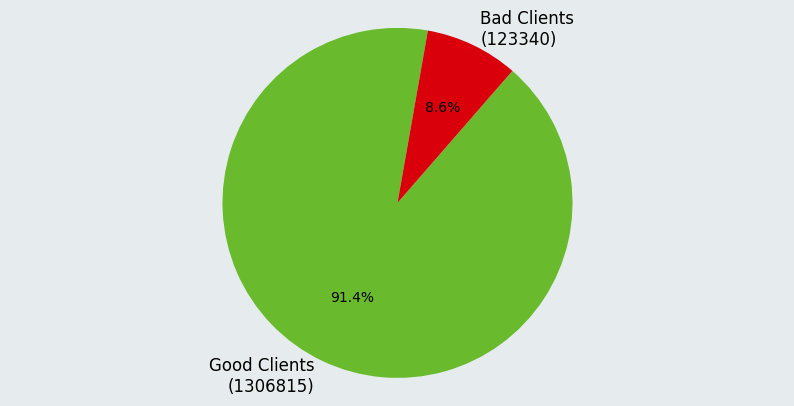

There's 1430155 Clients in our data


In [16]:
counts = train_full['TARGET'].value_counts()
fig, ax = plt.subplots(figsize=(10, 5))
fig.patch.set_facecolor('#e6ebed')
gbp = ['#69ba2d', '#d9000c']

wedges, texts, autotexts = ax.pie(counts,
                                   labels=['Good Clients', 'Bad Clients'],
                                   autopct='%1.1f%%',
                                   colors=gbp,
                                   startangle=80)

plt.axis('equal')
for i, text in enumerate(texts):
    text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
    texts[i].set_fontsize(12)
plt.show()
print(f"There's {train_full.shape[0]} Clients in our data")

From the plot above, we can see that:
- From total 1430155 clients in our data.
- 1,306,815 (91.4%) clients don't have payment difficulties. 
- 123,340 (8.6%) clients have payments difficulties.
- The data is highly imbalanced.

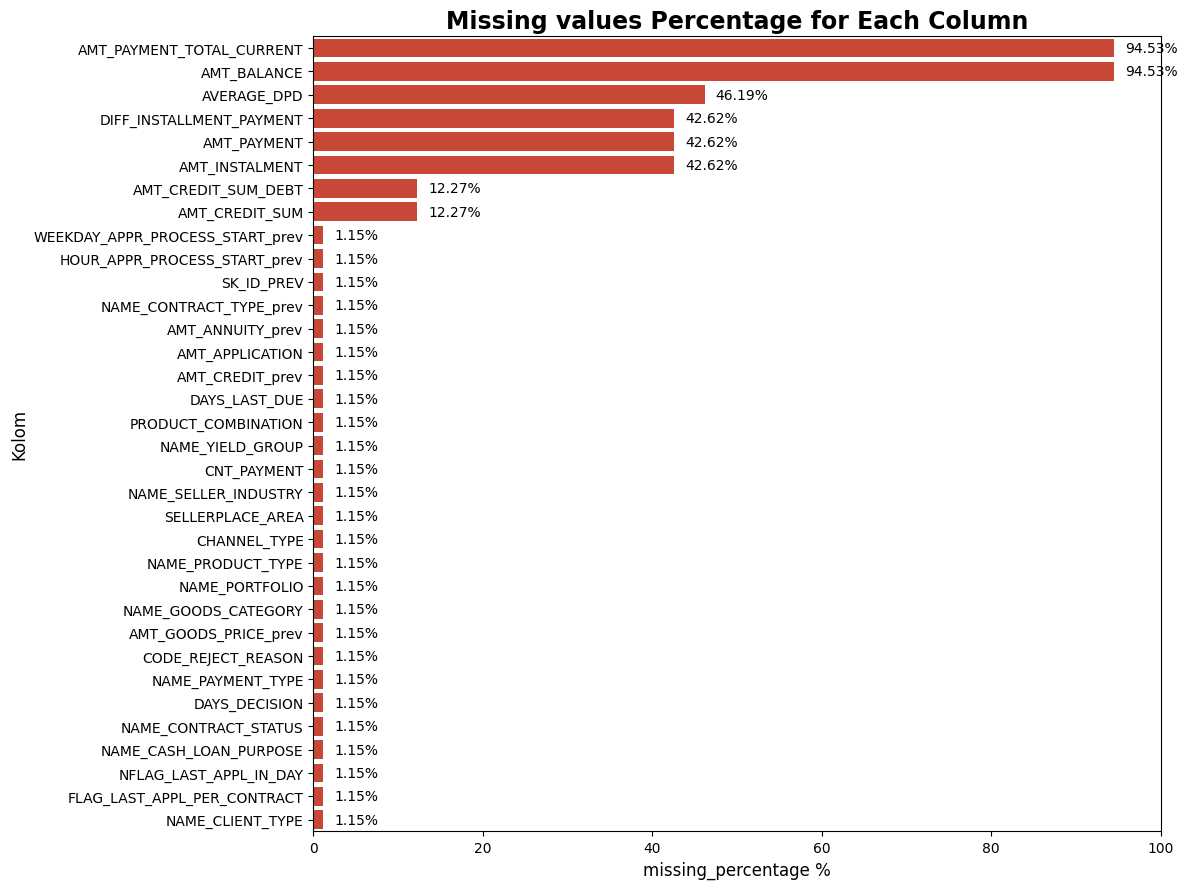

In [13]:
ms.plot_missing_percentage(train_full)

Our data Contains a lot of missing values,
- For the columns that have missing values more than 90% of the data, i will drop them.
- AVERAGE DPD missing values seems reasonable, that there's client that didn't have any DPD, or didn't have any previous application.
- for the columns `DIFF_INSTALMENT_PAYMENT`, `AMT_PAYMENT` and `AMT_INSTALMENT` i will fill the missing values with 0, because it's reasonable to assume that the client didn't have any previous application too.
- the rest of it i will leave it be, so when there's missing values, while we do woe binning, it will be treated as a separate category.

In [18]:
train_full = pd.merge(train_bureau, prev_pc, on='SK_ID_CURR', how='left', suffixes=('_curr', '_prev'))
# x train categorical value binning
train_full['AGE'] = round(abs(train_full['DAYS_BIRTH'] / 365.25)).astype(int)

train_full = train_full[train_full.NAME_FAMILY_STATUS != 'Unknown']
train_full = train_full.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
                                      'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION', 'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE'], axis=1)

replace_nan = {'XNA': np.nan}
train_full['NAME_YIELD_GROUP'] = train_full['NAME_YIELD_GROUP'].replace(replace_nan)

mapping_dict = {'Family' : 'Companied',
                'Spouse, partner': 'Companied',
                'Children': 'Companied',
                'Other_A': 'Companied',
                'Other_B': 'Companied',
                'Group of people': 'Companied'}
train_full = train_full.replace({'NAME_TYPE_SUITE': mapping_dict})

map_income_val = {'Unemployed': 'Others', 
                  'Student': 'Others', 
                  'Materniity leave': 'Others',
                  'Businessman': 'Others'}

train_full = train_full.replace({'NAME_INCOME_TYPE': map_income_val})

train_full = train_full.drop(columns=['SK_ID_CURR', 'SK_ID_PREV'], axis=1)

## Oulier Cheking

In [30]:
# numvisual = train_full[[
#     'CNT_CHILDREN', 'AMT_INCOME_TOTAL','AMT_CREDIT_curr', 'AMT_ANNUITY_curr',
#     'AMT_GOODS_PRICE_curr','REGION_POPULATION_RELATIVE','DAYS_BIRTH',
#     'DAYS_EMPLOYED','DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS',
#     'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_curr',
#     'EXT_SOURCE_2','OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
#     'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
#     'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_ANNUITY_prev', 'AMT_APPLICATION',
#     'AMT_CREDIT_prev','AMT_GOODS_PRICE_prev', 'HOUR_APPR_PROCESS_START_prev',
#     'NFLAG_LAST_APPL_IN_DAY', 'DAYS_DECISION', 'SELLERPLACE_AREA',
#     'CNT_PAYMENT', 'DAYS_LAST_DUE', 'AMT_INSTALMENT', 'AMT_PAYMENT',
#     'DIFF_INSTALLMENT_PAYMENT', 'AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT',
#     'AVERAGE_DPD'
#           ]].copy()

# colgroup = [numvisual.columns[n:n+4] for n in range(0, len(numvisual.columns), 4)]

# # Create a 9x4 grid of subplots
# fig, axs = plt.subplots(4, 10, figsize=(30, 15))

# # for each group of 4 columns
# for i, group in enumerate(colgroup):
#     # For eachg column in the group
#     for j, column in enumerate(group):
#         # Create a boxplot for the apporopriate subplot
#         sns.boxplot(y=numvisual[column], ax=axs[j, i ], color='blue', linewidth=1.5, orient='v')
#         axs[j, i].set_title(column)

# # show plot
# plt.tight_layout()
# plt.show()

## Train Test Split

In [19]:
X = train_full.drop(columns='TARGET', axis=1)
y = train_full[['TARGET']]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1103)

## Handle Missing Values

In [11]:
# # X train missing values handling
# fillzero = ['AVERAGE_DPD', 'DIFF_INSTALLMENT_PAYMENT', 'AMT_PAYMENT', 'AMT_INSTALMENT']
# X_train_c1 = ms.dropnan(X_train, 0.9)
# X_train_c2 = X_train_c1.copy()
# X_train_c2[fillzero] = X_train_c2[fillzero].fillna(0)


# # train_missing = X_train_c2[X_train_c2.columns[X_train_c2.isna().any()]] 
# # traincol = train_missing.columns

# # for col in traincol:
# #     if X_train_c2[col].dtype == 'object':
# #         X_train_c2[col].fillna(X_train_c2[col].mode()[0], inplace=True)
# #     else:
# #         X_train_c2[col].fillna(X_train_c2[col].median(), inplace=True)


# # X test missing values handling
# X_test_c1 = ms.dropnan(X_test, 0.9)
# X_test_c2 = X_test[fillzero].fillna(0)


# # test_missing = X_test_c2[X_test_c2.columns[X_test_c2.isna().any()]]
# # testcol = test_missing.columns

# # for col in testcol:
# #     if X_test_c2[col].dtype == 'object':
# #         X_test_c2[col].fillna(X_test_c2[col].mode()[0], inplace=True)
# #     else:
# #         X_test_c2[col].fillna(X_test_c2[col].median(), inplace=True)

## Data filtering

In [22]:
toad.quality(X_train, target=y_train['TARGET'], iv_only=True)

,iv,gini,entropy,unique
EXT_SOURCE_2,0.286217,NaN,NaN,116293.0
DAYS_EMPLOYED,0.101107,NaN,NaN,12433.0
AMT_GOODS_PRICE_curr,0.090048,NaN,NaN,977.0
DAYS_BIRTH,0.078253,NaN,NaN,17445.0
AGE,0.077581,NaN,NaN,49.0
...,...,...,...,...
NFLAG_LAST_APPL_IN_DAY,0.000133,NaN,NaN,3.0
REG_REGION_NOT_LIVE_REGION,0.000119,NaN,NaN,2.0
FLAG_EMAIL,0.000024,NaN,NaN,2.0
FLAG_MOBIL,0.000023,NaN,NaN,2.0


In [22]:
# train_selected, drop_list = toad.selection.select(frame=train_full,
#                                                   target=train_full['TARGET'],
#                                                   empty=0.5,
#                                                   iv=0.02,
#                                                   corr=0.7,
#                                                   return_drop=True)

# print(f'Number of features selected: {len(train_selected.columns)}')
# print(f'Number of features dropped: {len(drop_list)}')

In [20]:
Xtrain_selected, drop_list = toad.selection.select(frame=X_train,
                                                  target=y_train['TARGET'],
                                                  empty=0.5,
                                                  iv=0.02,
                                                  corr=0.7,
                                                  return_drop=True)

print("keep:",Xtrain_selected.shape[1],
      "drop empty:",len(drop_list['empty']),
      "drop iv:",len(drop_list['iv']),
      "drop corr:",len(drop_list['corr']))

display(Xtrain_selected)
print(f'\n{drop_list}')

keep: 22 drop empty: 2 drop iv: 40 drop corr: 6


,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
7003,M,225000.0,Working,Incomplete higher,0.018801,-9142,-746,-4016.0,-1805,2,1,0.402901,-1393.0,46462.500,Approved,-1393.0,6.0,high,-1212.0,31133.970,5194.845,0.000000
792634,M,225000.0,Commercial associate,Secondary / secondary special,0.046220,-9036,-149,-1079.0,-1506,1,0,0.733094,-676.0,139437.000,Approved,-398.0,6.0,middle,-217.0,96675.255,16112.745,0.714286
604873,F,225000.0,Commercial associate,Secondary / secondary special,0.014520,-11704,-732,-4347.0,-4374,2,1,0.344191,-238.0,533709.000,Approved,-2587.0,6.0,high,-2402.0,22579.785,0.000,0.000000
360692,M,675000.0,Commercial associate,Higher education,0.019689,-12562,-1257,-6477.0,-3825,2,0,0.473022,-1438.0,220599.000,Approved,-1409.0,6.0,middle,-1227.0,126868.680,21145.455,0.000000
1389608,F,238500.0,Working,Secondary / secondary special,0.035792,-14333,-983,-7818.0,-4610,2,1,0.020813,-602.0,35860.500,Canceled,-169.0,0.0,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,F,270000.0,Commercial associate,Incomplete higher,0.031329,-10380,-921,-4866.0,-3042,2,1,0.444848,-954.0,69386.355,Approved,-2380.0,6.0,high,-2259.0,27904.050,0.000,0.000000
1419949,F,405000.0,Pensioner,Secondary / secondary special,0.025164,-20659,365243,-4696.0,-4150,2,0,0.194499,-593.0,108.000,Approved,-1155.0,0.0,NaN,-526.0,592256.520,0.000,NaN
734248,F,801000.0,State servant,Secondary / secondary special,0.015221,-14070,-6650,-8163.0,-5151,2,0,0.499346,-1110.0,49782.240,Approved,-665.0,0.0,NaN,365243.0,NaN,NaN,NaN
509864,F,409500.0,Commercial associate,Secondary / secondary special,0.002134,-10528,-342,-4236.0,-185,3,1,0.239021,-872.0,NaN,Canceled,-382.0,0.0,NaN,0.0,NaN,NaN,NaN



{'empty': array(['AMT_BALANCE', 'AMT_PAYMENT_TOTAL_CURRENT'], dtype='<U25'), 'iv': array(['NAME_CONTRACT_TYPE_curr', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'NAME_TYPE_SUITE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'WEEKDAY_APPR_PROCESS_START_curr',
       'HOUR_APPR_PROCESS_START_curr', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'LIVE_CITY_NOT_WORK_CITY',
       'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'AMT_CREDIT_SUM', 'NAME_CONTRACT_TYPE_prev', 'AMT_ANNUITY_prev',
       'AMT_APPLICATION', 'AMT_CREDIT_prev', 'AMT_GOODS_PRICE_prev',
       'WEEKDAY_APPR_PROCESS_START_prev', 'HOUR_APPR_PROCESS_START_prev',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAS

In [21]:
# output the iv table to a dataframe
def iv_importance(data_selected, label):
    iv_import_feat = toad.quality(data_selected, label, iv_only=True)
    iv_import_feat = iv_import_feat['iv']
    iv_import_feat = iv_import_feat.reset_index()
    iv_import_feat.columns = ['name', 'iv']
    return iv_import_feat

df_iv = iv_importance(Xtrain_selected, y_train['TARGET'])

In [22]:
df_iv.sort_values(by='iv', ascending=False)

,name,iv
0,EXT_SOURCE_2,0.286217
1,DAYS_EMPLOYED,0.101107
2,AMT_GOODS_PRICE_curr,0.090048
3,DAYS_BIRTH,0.078253
4,AMT_CREDIT_SUM_DEBT,0.069113
5,NAME_INCOME_TYPE,0.056678
6,DAYS_LAST_PHONE_CHANGE,0.055948
7,REGION_RATING_CLIENT_W_CITY,0.046869
8,REGION_POPULATION_RELATIVE,0.043548
9,DAYS_ID_PUBLISH,0.040655


## Feature Binning

In [23]:
# combine x_train and y_train
train = pd.concat([Xtrain_selected, y_train], axis=1)
sample = train.sample(frac=0.25, random_state=1103)

c = toad.transform.Combiner()
c.fit(X=sample.drop('TARGET', axis=1), y=sample['TARGET'], method='chi', min_samples=0.05, n_bins=None, empty_separate=True)

In [36]:
bins_output = c.export()
bins_output

{'CODE_GENDER': [['XNA', 'F'], ['M']],
 'AMT_GOODS_PRICE_curr': [137142.0,
  283500.0,
  418500.0,
  450234.0,
  634500.0,
  679500.0,
  904500.0],
 'NAME_INCOME_TYPE': [['Pensioner', 'State servant'],
  ['Commercial associate'],
  ['Working', 'Others', 'Maternity leave']],
 'NAME_EDUCATION_TYPE': [['Academic degree', 'Higher education'],
  ['Incomplete higher', 'Secondary / secondary special', 'Lower secondary']],
 'REGION_POPULATION_RELATIVE': [0.00702,
  0.018029,
  0.01885,
  0.020246,
  0.022625,
  0.032561],
 'DAYS_BIRTH': [-21032, -16266, -13338],
 'DAYS_EMPLOYED': [-3630, -2482, -1476, -923, 365243],
 'DAYS_REGISTRATION': [-6985.0, -4244.0, -1556.0],
 'DAYS_ID_PUBLISH': [-4033, -2596],
 'REGION_RATING_CLIENT_W_CITY': [2, 3],
 'REG_CITY_NOT_WORK_CITY': [1],
 'EXT_SOURCE_2': [0.3939235110548089, 0.6650312493057249],
 'DAYS_LAST_PHONE_CHANGE': [-1990.0, -1151.0, -911.0, -724.0, -7.0],
 'AMT_CREDIT_SUM_DEBT': [0.27, 468370.89, nan],
 'NAME_CONTRACT_STATUS': [['nan', 'Approved'],
  

In [24]:
tf_train_bin = c.transform(train)

# combine X_test and y_test
test = pd.concat([X_test, y_test], axis=1)
tf_test_bin = c.transform(test[tf_train_bin.columns])

In [25]:
display(tf_train_bin)
display(tf_test_bin)

,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD,TARGET
7003,1,1,2,1,2,3,4,2,2,1,1,1,1,1,0,1,1,3,0,0,1,0,0
792634,1,1,1,1,6,3,4,3,2,0,0,2,4,1,0,3,1,2,1,2,1,1,0
604873,0,1,1,1,1,3,4,1,0,1,1,0,4,2,0,0,1,3,0,0,0,0,1
360692,1,5,1,0,3,3,3,1,1,1,0,1,1,1,0,1,1,2,0,2,1,0,0
1389608,0,1,2,1,6,2,3,0,0,1,1,0,4,1,1,4,0,4,2,3,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,0,1,1,1,5,3,4,1,1,1,1,1,2,1,0,1,1,3,0,0,0,0,0
1419949,0,2,0,1,5,1,5,1,0,1,0,0,4,1,0,1,0,4,1,2,0,2,0
734248,0,6,0,1,1,2,0,0,0,1,0,1,2,1,0,3,0,4,3,3,2,2,0
509864,0,2,1,1,0,3,4,2,2,2,1,0,3,3,1,3,0,4,2,3,2,2,0


,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD,TARGET
731711,0,5,2,1,3,2,0,2,1,1,0,0,4,2,0,1,2,2,0,2,1,1,0
480807,0,4,0,0,1,1,0,3,1,2,0,1,1,2,0,1,2,3,0,1,0,0,0
1240274,0,4,2,1,0,1,0,0,2,1,1,2,4,2,0,3,2,2,1,2,0,0,0
900521,0,0,1,0,3,3,2,2,2,1,1,1,0,1,1,4,0,4,2,3,2,2,0
827722,0,6,1,1,5,1,2,0,0,1,0,0,1,0,0,4,3,1,3,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547023,0,1,0,1,0,0,5,0,0,1,0,2,2,1,2,4,0,4,2,3,2,2,0
936177,0,3,0,1,5,0,5,0,0,1,0,2,1,0,1,3,0,4,2,3,2,2,0
890763,0,4,1,1,5,3,4,3,2,1,0,1,4,2,0,3,4,3,2,3,2,2,1
299560,1,6,0,1,0,0,3,0,0,2,0,1,2,1,0,2,1,2,0,1,1,1,0


In [41]:
# # intialize toad transformer
# c = toad.transform.Combiner()

# # fit the transformer
# c.fit(X=train_selected, y='TARGET', method='chi', min_samples=0.5, n_bins=10, empty_separate=True)

<Axes: xlabel='DAYS_EMPLOYED', ylabel='prop'>

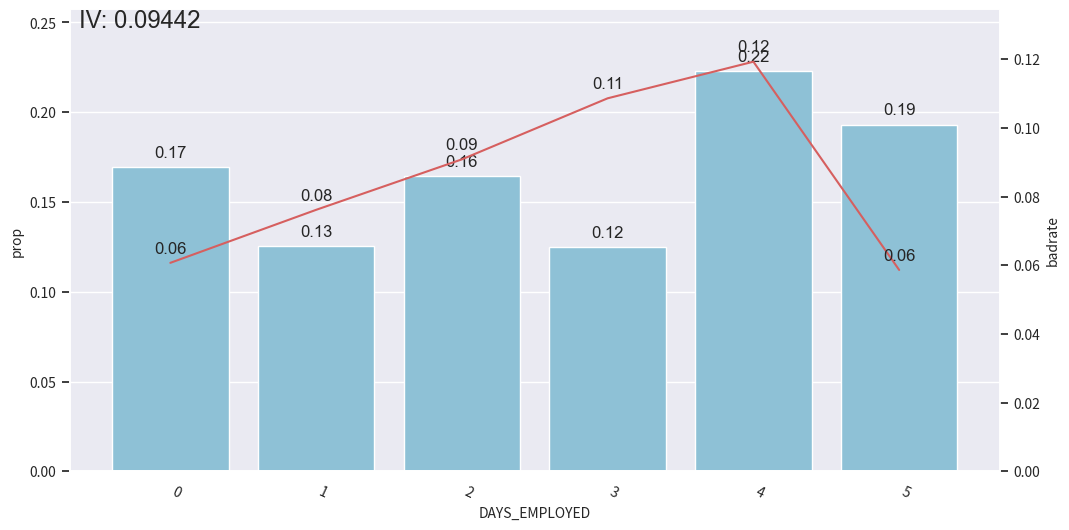

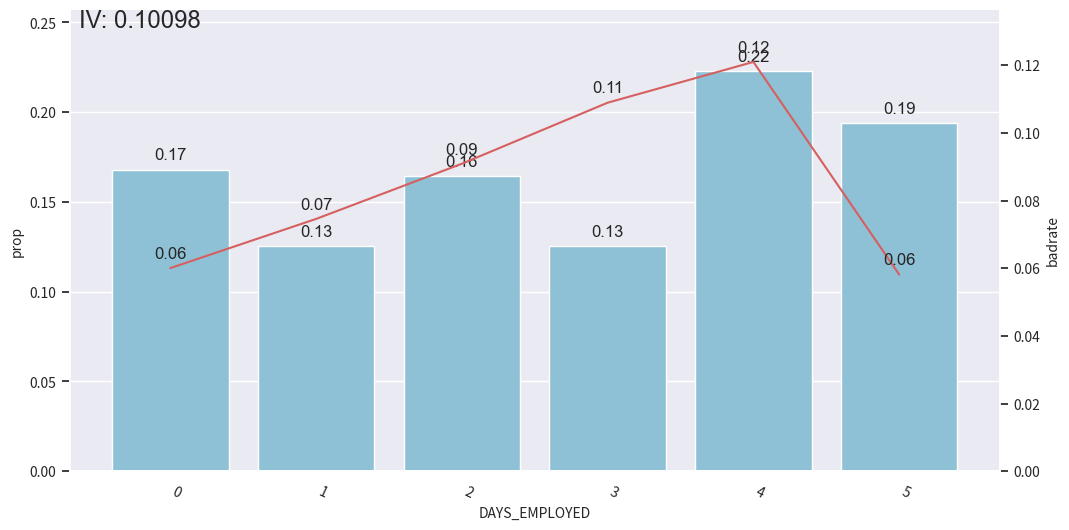

In [43]:
bin_plot(tf_train_bin, x='DAYS_EMPLOYED', target='TARGET')
bin_plot(tf_test_bin, x='DAYS_EMPLOYED', target='TARGET')

## Transform to WoE

In [45]:
td = toad.transform.WOETransformer()

# transform training set
train_woe = td.fit_transform(X=tf_train_bin, y='TARGET')

# transform test set
test_woe = td.transform(tf_test_bin)

In [27]:
train_woe

,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD,TARGET
7003,0.239880,0.025234,0.187157,0.093482,0.278252,0.290221,0.361284,0.057841,0.195905,-0.025484,0.289837,-0.136488,-0.200590,-0.018128,-0.143675,-0.203640,-0.218242,0.112974,-0.253158,-0.042289,0.142550,-0.200680,0
792634,0.239880,0.025234,-0.071250,0.093482,-0.415402,0.290221,0.361284,0.183992,0.195905,-0.522359,-0.097026,-0.758588,0.256272,-0.018128,-0.143675,0.097948,-0.218242,-0.078790,-0.083824,-0.182000,0.142550,0.206279,0
604873,-0.135218,0.025234,-0.071250,0.093482,0.010608,0.290221,0.361284,0.026136,-0.239121,-0.025484,0.289837,0.605481,0.256272,0.205211,-0.143675,-0.341560,-0.218242,0.112974,-0.253158,-0.042289,-0.223118,-0.200680,1
360692,0.239880,0.133007,-0.071250,-0.396554,-0.099329,0.290221,0.255631,0.026136,-0.001981,-0.025484,-0.097026,-0.136488,-0.200590,-0.018128,-0.143675,-0.203640,-0.218242,-0.078790,-0.253158,-0.182000,0.142550,-0.200680,0
1389608,-0.135218,0.025234,0.187157,0.093482,-0.415402,0.053181,0.255631,-0.243056,-0.239121,-0.025484,0.289837,0.605481,0.256272,-0.018128,0.066298,0.131900,0.151457,0.134706,0.192645,0.159109,0.159109,0.164855,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,-0.135218,0.025234,-0.071250,0.093482,-0.025078,0.290221,0.361284,0.026136,-0.001981,-0.025484,0.289837,-0.136488,0.023227,-0.018128,-0.143675,-0.203640,-0.218242,0.112974,-0.253158,-0.042289,-0.223118,-0.200680,0
1419949,-0.135218,0.264115,-0.397122,0.093482,-0.025078,-0.124246,-0.415423,0.026136,-0.239121,-0.025484,-0.097026,0.605481,0.256272,-0.018128,-0.143675,-0.203640,0.151457,0.134706,-0.083824,-0.182000,-0.223118,0.164855,0
734248,-0.135218,-0.256675,-0.397122,0.093482,0.010608,0.053181,-0.378583,-0.243056,-0.239121,-0.025484,-0.097026,-0.136488,0.023227,-0.018128,-0.143675,0.097948,0.151457,0.134706,-0.016607,0.159109,0.159109,0.164855,0
509864,-0.135218,0.264115,-0.071250,0.093482,0.107104,0.290221,0.361284,0.057841,0.195905,0.383666,0.289837,0.605481,0.097610,0.220591,0.066298,0.097948,0.151457,0.134706,0.192645,0.159109,0.159109,0.164855,0


## Model Tuning

Train KS: 0.30076381537554775
Test_KS: 0.30365723127072797
Train AUC: 0.7041208191261958
Test AUC: 0.7057564239663474
Train Recall: 0.6552536839032618
Test Recall: 0.6575560094673022


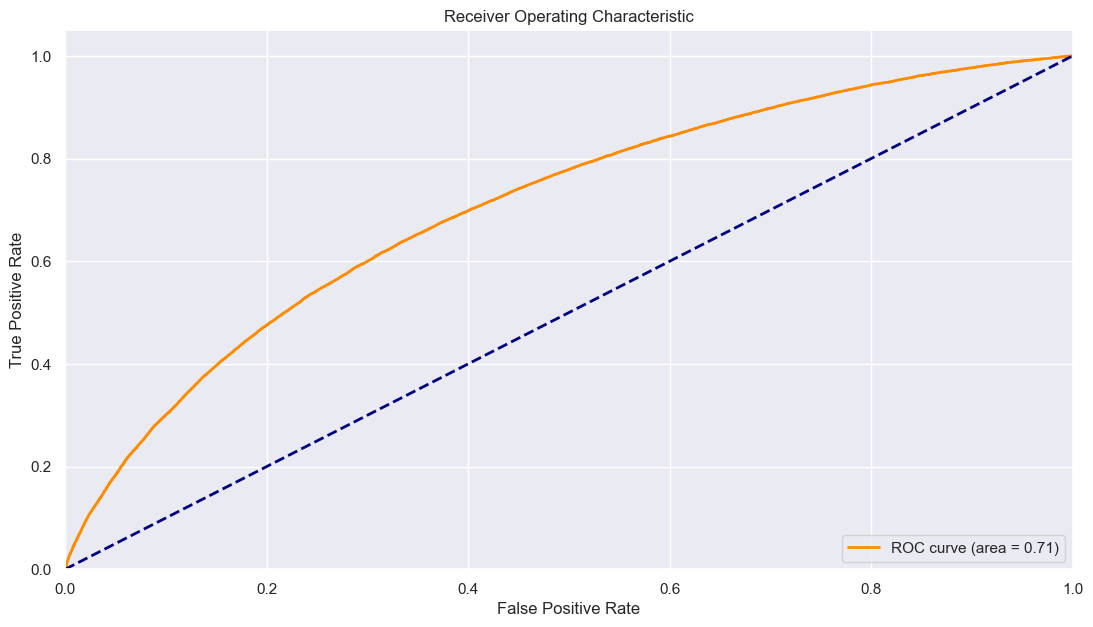

In [46]:
def train_test_auc(X_train, y_train, x_test, y_test):
    lr = LogisticRegression(random_state=1103, class_weight='balanced', C= 0.1, solver='newton-cg')
    lr.fit(X_train, y_train)

    pred_train = lr.predict_proba(X_train)[:, 1]
    pred_test = lr.predict_proba(x_test)[:, 1]

    print('Train KS:', KS(pred_train, y_train))
    print('Test_KS:', KS(pred_test, y_test))

    print('Train AUC:', AUC(pred_train, y_train))
    print('Test AUC:', AUC(pred_test, y_test))

    print('Train Recall:', recall_score(y_train, pred_train > 0.5))
    print('Test Recall:', recall_score(y_test, pred_test > 0.5))

    fig, ax = plt.subplots(figsize=(13, 7))
    
    fpr, tpr, _ = roc_curve(y_test, pred_test)
    roc_auc = roc_auc_score(y_test, pred_test)

    # Plot ROC Curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

X_train2 = train_woe.drop('TARGET', axis=1).copy()
X_test2 = test_woe.drop('TARGET', axis=1).copy()
train_test_auc(X_train=X_train2, y_train=train_woe['TARGET'],
               x_test=X_test2, y_test=test_woe['TARGET'])

The KS (Kolmogorov-Smirnov) statistic and AUC (Area Under the ROC Curve) are both metrics used to evaluate the performance of a binary classification model.

1. **KS Statistic**: The KS statistic measures the maximum difference between the cumulative true positive rate and the cumulative false positive rate over all possible thresholds. A higher KS statistic means that the model is better at distinguishing between positive and negative instances. In this case, the KS statistic is around 0.30 for both the training and test sets, which suggests that our model has a moderate ability to distinguish between the two classes.

2. **AUC**: The AUC measures the area under the ROC curve, which plots the true positive rate against the false positive rate at various threshold settings. The AUC ranges from 0 to 1, where a value of 0.5 corresponds to a model that makes random predictions, and a value of 1 corresponds to a model that makes perfect predictions. In our case, the AUC is around 0.70 for both the training and test sets, which suggests that our model has a good predictive performance.

The fact that the KS and AUC values are similar for the training and test sets is a good sign. It suggests that our model is not overfitting to the training data, as it performs similarly on unseen data (the test set).

In [53]:
# def get_evaluation_scores(label, predictions):
#     print('Confusion Matrix: ')
#     print(confusion_matrix(label, predictions))
#     print('Accuracy: ', accuracy_score(label, predictions))
#     print('Precision: ', precision_score(label, predictions))
#     print('Recall: ', recall_score(label, predictions))
#     print('F1 score: ', f1_score(label, predictions))
#     print('Classification Report: ')
#     print(classification_report(label, predictions))
#     print('Balanced Accuracy Score: ', balanced_accuracy_score(label, predictions))

# def evaluate_result(df_train, df_test, features_name):
#     start = time.time()
#     x_train = df_train[features_name]
#     y_train = df_train['label']
#     x_test  = df_test[features_name]
#     y_test  = df_test['label']

#     model = GradientBoostingClassifier(n_estimators=250, random_state=0)
#     model.fit(x_train, y_train)
#     predictions = model.predict(x_test)
#     get_evaluation_scores(label = y_test, predictions=predictions)

#     feat_importances = pd.Series(model.feature_importances_, index=features_name)
#     feat_importances = feat_importances.sort_values(ascending=False)
#     plt.figure(figsize=(15,15))
#     sns.barplot(x=feat_importances, y=feat_importances.index)
#     plt.title("Features Importance", size=18)
#     plt.ylabel('', size = 15)
#     plt.tick_params(labelsize=18)

#     print('Time taken: ', time.time() - start)

#     return feat_importances, model, x_train, y_train, x_test, y_test

# fet_importance_GBDT_reason, model, x_train, y_train, x_test, y_test = evaluate_result(df_train=train_woe, df_test=test_woe, features_name=`train_woe.columns.drop`)

## Scorecard Model

In [56]:
train_woe.drop(columns='TARGET')


,CODE_GENDER,AMT_GOODS_PRICE_curr,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE,AMT_CREDIT_SUM_DEBT,NAME_CONTRACT_STATUS,DAYS_DECISION,CNT_PAYMENT,NAME_YIELD_GROUP,DAYS_LAST_DUE,AMT_PAYMENT,DIFF_INSTALLMENT_PAYMENT,AVERAGE_DPD
7003,0.239880,0.025234,0.187157,0.093482,0.278252,0.290221,0.361284,0.057841,0.195905,-0.025484,0.289837,-0.136488,-0.200590,-0.018128,-0.143675,-0.203640,-0.218242,0.112974,-0.253158,-0.042289,0.142550,-0.200680
792634,0.239880,0.025234,-0.071250,0.093482,-0.415402,0.290221,0.361284,0.183992,0.195905,-0.522359,-0.097026,-0.758588,0.256272,-0.018128,-0.143675,0.097948,-0.218242,-0.078790,-0.083824,-0.182000,0.142550,0.206279
604873,-0.135218,0.025234,-0.071250,0.093482,0.010608,0.290221,0.361284,0.026136,-0.239121,-0.025484,0.289837,0.605481,0.256272,0.205211,-0.143675,-0.341560,-0.218242,0.112974,-0.253158,-0.042289,-0.223118,-0.200680
360692,0.239880,0.133007,-0.071250,-0.396554,-0.099329,0.290221,0.255631,0.026136,-0.001981,-0.025484,-0.097026,-0.136488,-0.200590,-0.018128,-0.143675,-0.203640,-0.218242,-0.078790,-0.253158,-0.182000,0.142550,-0.200680
1389608,-0.135218,0.025234,0.187157,0.093482,-0.415402,0.053181,0.255631,-0.243056,-0.239121,-0.025484,0.289837,0.605481,0.256272,-0.018128,0.066298,0.131900,0.151457,0.134706,0.192645,0.159109,0.159109,0.164855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11300,-0.135218,0.025234,-0.071250,0.093482,-0.025078,0.290221,0.361284,0.026136,-0.001981,-0.025484,0.289837,-0.136488,0.023227,-0.018128,-0.143675,-0.203640,-0.218242,0.112974,-0.253158,-0.042289,-0.223118,-0.200680
1419949,-0.135218,0.264115,-0.397122,0.093482,-0.025078,-0.124246,-0.415423,0.026136,-0.239121,-0.025484,-0.097026,0.605481,0.256272,-0.018128,-0.143675,-0.203640,0.151457,0.134706,-0.083824,-0.182000,-0.223118,0.164855
734248,-0.135218,-0.256675,-0.397122,0.093482,0.010608,0.053181,-0.378583,-0.243056,-0.239121,-0.025484,-0.097026,-0.136488,0.023227,-0.018128,-0.143675,0.097948,0.151457,0.134706,-0.016607,0.159109,0.159109,0.164855
509864,-0.135218,0.264115,-0.071250,0.093482,0.107104,0.290221,0.361284,0.057841,0.195905,0.383666,0.289837,0.605481,0.097610,0.220591,0.066298,0.097948,0.151457,0.134706,0.192645,0.159109,0.159109,0.164855


In [58]:
# scorecard tuning
card_model = toad.ScoreCard(
    combiner=c,
    transer=td,
    class_weight='balanced',
    C=0.1,
    base_score=600,
    base_odds=1/19,
    pdo=20,
    rate=2
)

card_model.fit(train_woe.drop(columns='TARGET'), train_woe['TARGET'])

# Inference test data
test['CREDIT_SCORE'] = card_model.predict(test)

# scorecard model output
final_scorecard = card_model.export()

#transform the scorecard into dataframe and save to csv
keys = list(card_model.export().keys())
score_card_df = pd.DataFrame()
for n in keys:
    temp = pd.DataFrame.from_dict(final_scorecard[n], orient='index')
    temp = temp.reset_index()
    temp.columns= ['binning','score']
    temp['variable'] = n
    temp = temp[['variable','binning','score']]
    score_card_df=pd.concat([score_card_df, temp])
score_card_df.head(30)

,variable,binning,score
0,CODE_GENDER,"XNA,F",33.72
1,CODE_GENDER,M,26.55
0,AMT_GOODS_PRICE_curr,[-inf ~ 137142.0),36.35
1,AMT_GOODS_PRICE_curr,[137142.0 ~ 283500.0),30.63
2,AMT_GOODS_PRICE_curr,[283500.0 ~ 418500.0),25.87
3,AMT_GOODS_PRICE_curr,[418500.0 ~ 450234.0),19.53
4,AMT_GOODS_PRICE_curr,[450234.0 ~ 634500.0),34.27
5,AMT_GOODS_PRICE_curr,[634500.0 ~ 679500.0),28.49
6,AMT_GOODS_PRICE_curr,[679500.0 ~ 904500.0),36.25
7,AMT_GOODS_PRICE_curr,[904500.0 ~ inf),39.49


In [60]:
train_full.CODE_GENDER.value_counts()

CODE_GENDER
F      964821
M      465277
XNA        55
Name: count, dtype: int64

## Handling Outlier

In [38]:
# def cap_outliers(data, columns):
#     # Create a copy of the data to avoid modifying the original DataFrame
#     result = data.copy()

#     # Loop over each column in the provided list
#     for col in columns:
#         # Calculate the first quartile (Q1) for the current column
#         Q1 = result[col].quantile(0.25)
#         # Calculate the third quartile (Q3) for the current column
#         Q3 = result[col].quantile(0.75)
#         # Calculate the Interquartile Range (IQR) for the current column
#         IQR = Q3 - Q1
#         # Calculate the lower bound for the current column
#         lower_bound = Q1 - (1.5 * IQR)
#         # Calculate the upper bound for the current column
#         upper_bound = Q3 + (1.5 * IQR)
#         # Replace values in the current column that are less than the lower bound with the lower bound
#         result[col] = np.where(result[col] < lower_bound, lower_bound, result[col])
#         # Replace values in the current column that are greater than the upper bound with the upper bound
#         result[col] = np.where(result[col] > upper_bound, upper_bound, result[col])
#     # Return the DataFrame with capped outliers
#     return result

In [39]:
# # Select the names of all numerical columns in the DataFrame X_train_c2
# outliers = X_train_c2.select_dtypes(include='number').columns

# # Call the cap_outliers function on X_train_c2, passing in the names of the numerical columns
# # This will cap the outliers in these columns, and the result is stored in X_train_c3
# X_train_c3 = cap_outliers(X_train_c2, outliers)

## Feature Engineering

In [40]:
# # x train categorical value binning
# X_train_c3['AGE'] = round(abs(X_train_c3['DAYS_BIRTH'] / 365.25)).astype(int)

# X_train_c3 = X_train_c3[X_train_c3.NAME_FAMILY_STATUS != 'Unknown']
# y_train = y_train.drop([194676, 868956])
# X_train_c3 = X_train_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
#                                       'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

# mapping_dict = {'Family' : 'Companied',
#                 'Spouse, partner': 'Companied',
#                 'Children': 'Companied',
#                 'Other_A': 'Companied',
#                 'Other_B': 'Companied',
#                 'Group of people': 'Companied'}
# X_train_c3 = X_train_c3.replace({'NAME_TYPE_SUITE': mapping_dict})

# map_income_val = {'Unemployed': 'Others', 
#                   'Student': 'Others', 
#                   'Materniity leave': 'Others',
#                   'Businessman': 'Others'}

# X_train_c3 = X_train_c3.replace({'NAME_INCOME_TYPE': map_income_val})


# # x test categorical value binning
# X_test_c3 = X_test_c2.copy()
# X_test_c3['AGE'] = round(abs(X_test_c3['DAYS_BIRTH'] / 365.25)).astype(int)

# X_test_c3 = X_test_c3[X_test_c3.NAME_FAMILY_STATUS != 'Unknown']
# X_test_c3 = X_test_c3.drop(columns=['ORGANIZATION_TYPE', 'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'NAME_GOODS_CATEGORY', 
#                                     'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis=1)

# X_test_c3 = X_test_c3.replace({'NAME_TYPE_SUITE': mapping_dict})
# X_test_c3 = X_test_c3.replace({'NAME_INCOME_TYPE': map_income_val})

## Feature Encoding

In [17]:
# from sklearn.preprocessing import LabelEncoder

# # Create a LabelEncoder object
# le = LabelEncoder()

# X_train_c4 = X_train_c3.copy()
# # Iterate over all values of each column and extract their dtypes
# for col in X_train_c4.columns:
#     # Compare if the dtype is object
#     if X_train_c4[col].dtype == 'object':
#     # Use LabelEncoder to do the numeric transformation
#         X_train_c4[col] = le.fit_transform(X_train_c4[col])
#         X_test_c3[col] = le.fit_transform(X_test_c3[col])

In [41]:
# # one hot encoding all categorical columns
# X_train_c4 = pd.get_dummies(X_train_c3, drop_first=True).astype(int)
# X_test_c4 = pd.get_dummies(X_test_c3, drop_first=True).astype(int)

## Feature Scaling

In [42]:
# scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(X_train_c4)

# X_test_scaled = scaler.transform(X_test_c4)

## Handle Imbalance data

In [27]:
# stomek = SMOTETomek(random_state=1103)
# X_over, y_over = stomek.fit_resample(X_train_scaled, y_train)

In [ ]:
# counts = y_over['TARGET'].value_counts()
# fig, ax = plt.subplots(figsize=(10, 5))
# fig.patch.set_facecolor('#e6ebed')
# gbp = ['#69ba2d', '#d9000c']

# wedges, texts, autotexts = ax.pie(counts,
#                                    labels=['Good Clients', 'Bad Clients'],
#                                    autopct='%1.1f%%',
#                                    colors=gbp,
#                                    startangle=80)

# plt.axis('equal')
# for i, text in enumerate(texts):
#     text.set(text=texts[i].get_text() + f'\n({counts.iloc[i]})')
#     texts[i].set_fontsize(12)
# plt.show()

## Model Building

In [46]:
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     # Fit the model to the training data
#     model.fit(X_train, y_train)
    
#     # Make predictions on the training data
#     y_train_pred = model.predict(X_train)
    
#     # Make predictions on the testing data
#     y_test_pred = model.predict(X_test)
    
#     # Calculate the accuracy for the training and testing data
#     train_accuracy = accuracy_score(y_train, y_train_pred)
#     test_accuracy = accuracy_score(y_test, y_test_pred)
    
#     # Calculate the precision for the training and testing data
#     train_precision = precision_score(y_train, y_train_pred)
#     test_precision = precision_score(y_test, y_test_pred)
    
#     # Calculate the recall for the training and testing data
#     train_recall = recall_score(y_train, y_train_pred)
#     test_recall = recall_score(y_test, y_test_pred)
    
#     # Calculate the F1 score for the training and testing data
#     train_f1 = f1_score(y_train, y_train_pred)
#     test_f1 = f1_score(y_test, y_test_pred)

#     # Calculate the ROC AUC for the training and testing data
#     train_roc_auc = roc_auc_score(y_train, y_train_pred)
#     test_roc_auc = roc_auc_score(y_test, y_test_pred)
    
#     return {
#         'model': model.__class__.__name__,
#         'train_recall': round(train_recall, 2),
#         'test_recall': round(test_recall, 2),
#         'train_roc_auc': round(train_roc_auc, 2),
#         'test_roc_auc': round(test_roc_auc, 2)
#     }

In [60]:
# # import xgboost model
# from xgboost import XGBClassifier

# # import gradient boosting model
# from sklearn.ensemble import GradientBoostingClassifier

# lr = LogisticRegression(random_state=1103, class_weight='balanced')
# xgb = XGBClassifier(random_state=1103)
# gbc = GradientBoostingClassifier(random_state=1103)

# models = [lr, xgb]

# results = [evaluate_model(model, X_train_scaled, y_train, X_test_scaled, y_test) for model in models]

# # Convert the results to a DataFrame
# df_model = pd.DataFrame(results)

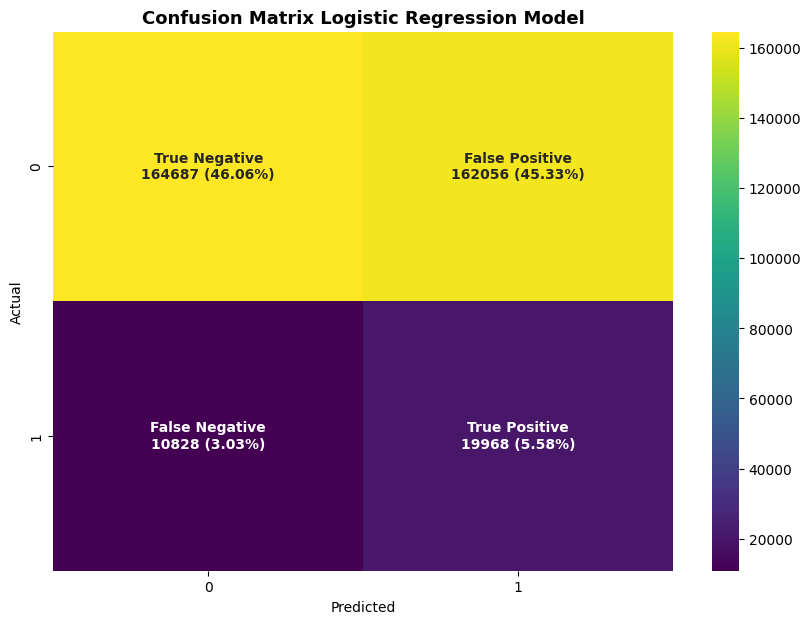

In [53]:
# # Assuming X_test is your test dataset and model is your Gradient Boosting model
# y_pred = lr.predict(X_test_scaled)

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_test, y_pred)

# # Calculate the percentage of each category
# percentage_matrix = cnf_matrix / cnf_matrix.sum()

# # Define the labels
# labels = np.array([['True Negative', 'False Positive'],
#                    ['False Negative', 'True Positive']])

# # Create labels with both count and percentage
# new_labels = (np.asarray(["{0}\n{1} ({2:.2%})".format(label, value, percentage)
#                           for label, value, percentage in zip(labels.flatten(), cnf_matrix.flatten(), percentage_matrix.flatten())])
#              ).reshape(2,2)

# # Plot confusion matrix using a heatmap
# fig = plt.figure(figsize=(10,7))
# fig.patch.set_facecolor('white')  # Change figure color

# sns.heatmap(cnf_matrix, annot=new_labels, fmt='', cmap='viridis', annot_kws={"weight": "bold"})
# plt.title('Confusion Matrix Logistic Regression Model', fontsize=13, fontweight='bold')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')

# # Change label colors
# plt.gca().xaxis.label.set_color('black')
# plt.gca().yaxis.label.set_color('black')

# plt.show()